# **FITS to HDF5**

In [1]:
import numpy as np
import pandas as pd
import h5py
import astropy.table
from astropy.table import Table
import astropy.io.fits as pf
import scipy
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
filename = '/home/raulteixeira/scratch-midway2/CosmicShearData/DES0939-0126COADD.fits'
data = Table.read(filename)

In [4]:
# filename = '/home/raulteixeira/scratch-midway2/CosmicShearData/cuts/metacal_sample_ID.npz'
# metacal_cuts = np.load(filename)['id']
# coadd_ids = data['COADD_OBJECT_ID']
# datadf = data.to_pandas()
# datametacal = datadf.loc[datadf['COADD_OBJECT_ID'].isin(metacal_cuts)]

In [40]:
# print(metacal_cuts.size)
# print(data['COADD_OBJECT_ID'].size)
# print(len(metacal_cuts)/data['COADD_OBJECT_ID'].size)

# onesig = np.std(datametacal[datametacal[f'MAG_AUTO_G']!=99.0]['MAG_AUTO_G'])
# pd.set_option('display.max_columns', None)
# datametacal[datametacal[f'MAG_AUTO_G']==99.0] = datametacal.assign(MAGERR_AUTO_G=onesig)
# plt.yscale('log')
# plt.hist(datametacal[datametacal['MAG_AUTO_G']!=99]['MAGERR_AUTO_G'], bins=300)
# plt.show()
# plt.yscale('log')
# plt.hist(datametacal['MAGERR_AUTO_G'][datametacal['MAGERR_AUTO_G']>10])
# plt.show()
# plt.hist(datametacal[f'MAGERR_AUTO_G'][datametacal['MAG_AUTO_G']==99], bins=30)
# plt.show()

# datametacal[datametacal['MAG_AUTO_G']<30]['MAGERR_AUTO_G'].size/datametacal['MAGERR_AUTO_G'].size

# bandlist = ['G', 'R', 'I', 'Z']
# for band in bandlist:
#     plt.xlabel(f'{band}')
#     plt.ylabel(f'{band} error')
#     plt.scatter(datametacal[f'MAG_AUTO_{band}'], datametacal[f'MAGERR_AUTO_{band}'], s=.5)
#     plt.show()

# s/g cut Y3
# WAVG_SPREAD_MODEL_I = datametacal['WAVG_SPREAD_MODEL_I']
# WAVG_SPREADERR_MODEL_I = datametacal['WAVG_SPREADERR_MODEL_I']

# s1 = (WAVG_SPREAD_MODEL_I + 3. * WAVG_SPREADERR_MODEL_I) > 0.005
# s2 = (WAVG_SPREAD_MODEL_I + 1. * WAVG_SPREADERR_MODEL_I) > 0.003
# s3 = (WAVG_SPREAD_MODEL_I - 1. * WAVG_SPREADERR_MODEL_I) > 0.001
# ext_wavg = s1.astype(int) + s2.astype(int) + s3.astype(int)
# sg_mask = (ext_wavg>=2)
# onesig = np.std(datametacal[datametacal[f'MAG_AUTO_G']!=99]['MAG_AUTO_G'])
# print(onesig)
# datametacal[datametacal[f'MAG_AUTO_G']==99.0] = datametacal.assign(MAGERR_AUTO_G=onesig)
# print("ratio of objects filtered out", 1-np.sum(sg_mask)/len(sg_mask), "\n# of objects filtered out", len(sg_mask)-np.sum(sg_mask), "\n# of objects", len(sg_mask))

In [6]:
data = Table.from_pandas(datametacal)

In [7]:
b_mask = data['MAG_AUTO_G']!=99
data = data[b_mask]

In [7]:
data30 = data[data['MAG_AUTO_G']<30]

In [8]:
data.write('/home/raulteixeira/scratch-midway2/CosmicShearData/METACALgals.fits')

NameError: name 'datametacal' is not defined

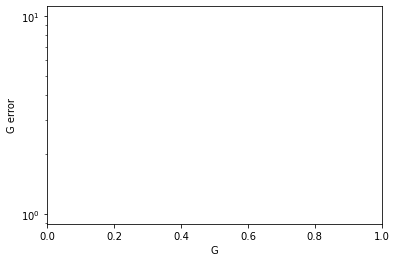

In [3]:
bandlist = ['G', 'R', 'I', 'Z']
for band in bandlist:
    plt.yscale('log')
    plt.xlabel(f'{band}')
    plt.ylabel(f'{band} error')
    plt.scatter(datametacal[f'MAG_AUTO_{band}'], datametacal[f'MAGERR_AUTO_{band}'], s=.5)
    plt.show()

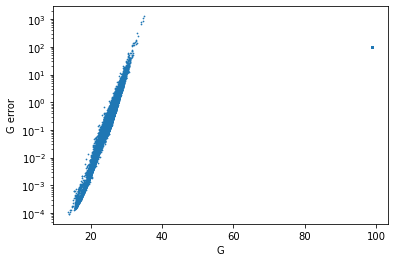

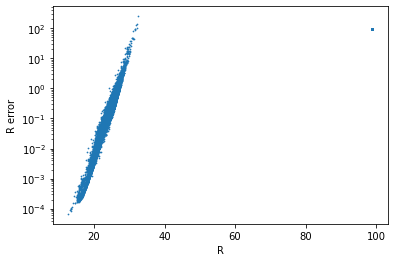

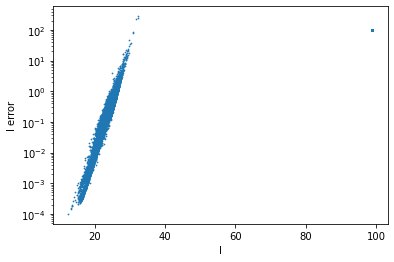

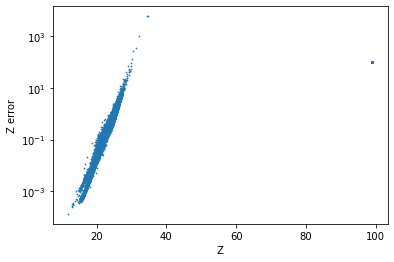

In [4]:
bandlist = ['G', 'R', 'I', 'Z']
for band in bandlist:
    plt.yscale('log')
    plt.xlabel(f'{band}')
    plt.ylabel(f'{band} error')
    plt.scatter(data[f'MAG_AUTO_{band}'], data[f'MAGERR_AUTO_{band}'], s=.5)
    plt.show()

In [8]:
tiles = np.unique(np.array(data['TILENAME']))

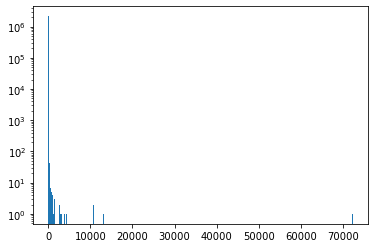

In [15]:
plt.yscale('log')
a = plt.hist(datametacal['MAGERR_AUTO_G'], bins=1000)

In [48]:
maxerr=.1
mask1 = datametacal['MAGERR_AUTO_G']<maxerr
mask2 = datametacal['MAGERR_AUTO_R']<maxerr
mask3 = datametacal['MAGERR_AUTO_I']<maxerr
mask4 = datametacal['MAGERR_AUTO_Z']<maxerr
errmask = np.logical_and(np.logical_and(mask1, mask2), np.logical_and(mask3, mask4))
print(mask1.sum()/datametacal['MAGERR_AUTO_G'].size)
print(mask2.sum()/datametacal['MAGERR_AUTO_G'].size)
print(mask3.sum()/datametacal['MAGERR_AUTO_G'].size)
print(mask4.sum()/datametacal['MAGERR_AUTO_G'].size)
print(errmask.sum()/datametacal['MAGERR_AUTO_G'].size)

0.3493877249724551
0.6442092917075625
0.6517550790530584
0.486666830705522
0.2715439974993188


In [37]:
#creating the table to be converted
for tile in np.unique(data['TILENAME']):
    #converting to pandas dataframe
    masktile=data['TILENAME']==tile
    table_i = data[masktile]['COADD_OBJECT_ID', 'TILENAME', 'MAG_AUTO_G', 'MAG_AUTO_R'\
                         , 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R'\
                         , 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z'] 
                         #[tab_all['extended_class']>1]
    dframe_i = pd.DataFrame(data=table_i['COADD_OBJECT_ID']\
                            , columns = ['COADD_OBJECT_ID'])
    for label in table_i.columns:
            dframe_i[label] = data[label][masktile]
    dframe_i.to_hdf(f'/home/raulteixeira/scratch-midway2/CosmicShearData/bpztiles/pzinput/pzinput_METACAL_4_bands_{tile}.h5', key='df')

In [9]:
for tile in np.unique(data['TILENAME']):
    #converting to pandas dataframe
    masktile=data30['TILENAME']==tile
    table_i = data30[masktile]['COADD_OBJECT_ID', 'TILENAME', 'MAG_AUTO_G', 'MAG_AUTO_R'\
                         , 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R'\
                         , 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z'] 
                         #[tab_all['extended_class']>1]
    dframe_i = pd.DataFrame(data=table_i['COADD_OBJECT_ID']\
                            , columns = ['COADD_OBJECT_ID'])
    for label in table_i.columns:
            dframe_i[label] = data30[label][masktile]
    dframe_i.to_hdf(f'/home/raulteixeira/scratch-midway2/CosmicShearData/bpztiles/pzinput/pzinput_METACAL_4_bands_30cut_{tile}.h5', key='df')

In [ ]:
tile = tiles[0].astype('str')

In [13]:
#converting to pandas dataframe
#masktile=data['TILENAME']==tile
table_i = data['NUMBER', 'MAG_AUTO_G', 'MAG_AUTO_R'\
                     , 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R'\
                     , 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z'] 
                     #[tab_all['extended_class']>1]
dframe_i = pd.DataFrame(data=table_i['NUMBER']\
                        , columns = ['COADD_OBJECT_ID'])
for label in table_i.columns:
        dframe_i[label] = data[label]
dframe_i.to_hdf('/home/raulteixeira/scratch-midway2/CosmicShearData/bpztiles/pzinput/pz_input_coadd_test.h5', key='df')

AttributeError: 'MaskedColumn' object has no attribute '_mask'